# Regression to Predict the runs scored given the type of bowlers expected to bowl and the state of the match

Here, we will consider all the data available as we trying to get a relation between the strike rate, and deliveries per wicket vs each type of bowler vs the expeted runs scored 

Input --> Batter,  Team , Ball number, Innings, Non- striker  
Ouput --> Runs

In [9]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../../Data/selected_data/processed_data_NRR_with_venues.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data['date'] = data['match_id'].apply(lambda x: x[-10: ])
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215252 entries, 0 to 215251
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   batter               215252 non-null  object        
 1   bowler               215252 non-null  object        
 2   non_striker          215252 non-null  object        
 3   runs_by_bat          215252 non-null  int64         
 4   extra_runs           215252 non-null  int64         
 5   total_runs_delivery  215252 non-null  int64         
 6   current_team_total   215252 non-null  int64         
 7   runs_remain          215252 non-null  float64       
 8   batter_runs          215252 non-null  int64         
 9   balls_faced          215252 non-null  int64         
 10  wickets_fallen       215252 non-null  int64         
 11  extra_type           215252 non-null  object        
 12  delivery             215252 non-null  float64       
 13  over          

In [10]:
data.iloc[:, 10:].head(20)

,wickets_fallen,extra_type,delivery,over,wicket_type,player_out,toss_decision,toss_winner,innings,venue,...,bowling_team,won,final_team_total,batter_type,non_striker_type,bowler_type,replacements,net_run_rate,host,date
0,0,-,1.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
1,0,-,2.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
2,0,-,3.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
3,0,-,4.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
4,0,-,5.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
5,0,-,6.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
6,0,-,1.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
7,0,-,2.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
8,0,-,3.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17
9,0,-,4.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,Australia,2017-02-17


In [11]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2]) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (
		    data['innings'].isin(innings))
	]

	player_data.head()

	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = ['date', 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over',
	    'delivery', 'wickets_fallen', 'bowling_team', 'batting_team', 'venue', 'toss_winner', 'runs_remain']
	player_scores = gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery',
	                      'wickets_fallen', 'current_team_total']]
	first_ball['first_ball'] = (
	    first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']
	player_scores['current_team_total'] = first_ball['current_team_total']
	player_scores['is_powerplay'] = first_ball['first_ball'] <= 30

    # convert toss win to boolean
	player_scores['toss_winner'] = (
	    player_scores['toss_winner'] == player_scores['batting_team']).astype(int);

    # when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker']
	    == player_name].index

	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, [
	    'batter_runs', 'balls_faced']] = [0, 0]

	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (
	    player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]

	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)

	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(
	    player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (
	    player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)

	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs',
	    'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 +
	                          matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis=1)

	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]

		if player_data.empty:
			return player_data.drop('match_id', axis=1)

		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced

		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop(
		    'match_id', axis=1)  # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby(
	    'match_id')['bowler_type'].value_counts().unstack(fill_value=0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(
	    remaining_ball_types, how='left', on='match_id')

	player_scores.fillna(0, inplace=True)
	
    
    # if batsman ended as non_striker, make him the batter and drop the nonstriker column
	player_scores['batter'] = player_name
	player_scores.drop('non_striker', inplace=True, axis = 1)



	# Sort according to date
	player_scores.sort_values(by='date', inplace=True)

	def calculate_recent_form(row, window=30):
		"""
		Calculates the average runs scored by the player in the last 'window' days (excluding the current date).
		"""
		date = row['date']
		df = player_scores.copy()
		df = df[df['date'] < date]
		df = df[df['date'] >= (date - pd.Timedelta(days=window))]
		average_runs = df['batter_runs'].mean() if len(df) > 0 else 0
		return average_runs	

	player_scores['recent_form'] = player_scores.apply(calculate_recent_form, axis=1)
	
	# reindex
	player_scores.reset_index(drop=True, inplace=True)

	return player_scores




In [12]:
# selected_batters = ["PWH de Silva",'KIC Asalanka','BKG Mendis',"P Nissanka",'PHKD Mendis','S Samarawickrama','AD Mathews','MD Shanaka','DM de Silva','M Theekshana','PVD Chameera','N Thushara','M Pathirana','D Madushanka']

merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    merged_df = pd.concat([merged_df, player_scores])

merged_df.to_csv('merged_df_checkpoint.csv')

Analyzing Player AJ Finch


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera
Analyzing Player DAS Gunaratne


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TAM Siriwardana
Analyzing Player CK Kapugedera


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Prasanna
Analyzing Player BR Dunk
Analyzing Player TD Paine


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PJ Cummins
Analyzing Player AJ Tye
Analyzing Player JA Richardson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player BKG Mendis
Analyzing Player KMDN Kulasekara


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SL Malinga
Analyzing Player MD Shanaka


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JRMVB Sanjaya
Analyzing Player KL Rahul


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AT Rayudu
Analyzing Player Mandeep Singh
Analyzing Player MK Pandey


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KM Jadhav
Analyzing Player MS Dhoni


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AR Patel
Analyzing Player R Dhawan
Analyzing Player CJ Chibhabha


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player H Masakadza
Analyzing Player R Mutumbami


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Sikandar Raza
Analyzing Player MN Waller


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CT Mutombodzi
Analyzing Player E Chigumbura
Analyzing Player AG Cremer


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player N Madziva
Analyzing Player PJ Moor
Analyzing Player DT Tiripano


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player T Muzarabani
Analyzing Player DS Kulkarni
Analyzing Player V Sibanda
Analyzing Player T Maruma
Analyzing Player Tamim Iqbal


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Imrul Kayes
Analyzing Player Sabbir Rahman
Analyzing Player Shakib Al Hasan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Soumya Sarkar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mahmudullah


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mosaddek Hossain


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mashrafe Mortaza


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Nurul Hasan
Analyzing Player Rubel Hossain


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NT Broom
Analyzing Player KS Williamson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player C Munro


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CJ Anderson
Analyzing Player TC Bruce
Analyzing Player C de Grandhomme


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mustafizur Rahman
Analyzing Player L Ronchi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JDS Neesham
Analyzing Player MJ Santner


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GD Phillips
Analyzing Player BM Wheeler


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TG Southee
Analyzing Player TA Boult


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player HM Amla
Analyzing Player Q de Kock


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player F du Plessis


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AB de Villiers


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JP Duminy


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player F Behardien
Analyzing Player CH Morris


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WD Parnell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JJ Roy


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AD Hales


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JM Bairstow


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JT Smuts
Analyzing Player RR Hendricks


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DA Miller


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SW Billings
Analyzing Player LS Livingstone


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JC Buttler


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player EJG Morgan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LA Dawson
Analyzing Player M Mosehle
Analyzing Player AL Phehlukwayo


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player M Morkel
Analyzing Player D Paterson
Analyzing Player DJ Malan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LE Plunkett
Analyzing Player DJ Willey


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player TK Curran
Analyzing Player JE Root
Analyzing Player AU Rashid


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CJ Jordan
Analyzing Player CH Gayle


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player E Lewis
Analyzing Player MN Samuels


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CAK Walton


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KA Pollard


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player R Powell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CR Brathwaite
Analyzing Player SP Narine
Analyzing Player AR Nurse


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JE Taylor
Analyzing Player KOK Williams
Analyzing Player BA Stokes


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player V Kohli


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SK Raina


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Yuvraj Singh
Analyzing Player HH Pandya


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Parvez Rasool
Analyzing Player MM Ali


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TS Mills
Analyzing Player RR Pant
Analyzing Player RG Sharma


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AM Rahane
Analyzing Player J Charles


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AD Russell
Analyzing Player DJ Bravo


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LMP Simmons
Analyzing Player Sharjeel Khan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Khalid Latif
Analyzing Player Babar Azam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player ADS Fletcher
Analyzing Player N Pooran


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Badree
Analyzing Player Shoaib Malik


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Sarfraz Ahmed
Analyzing Player Umar Akmal


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DA Warner


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DJM Short
Analyzing Player CA Lynn
Analyzing Player GJ Maxwell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MJ Guptill


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LRPL Taylor


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TA Blundell
Analyzing Player IS Sodhi
Analyzing Player MP Stoinis


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AT Carey
Analyzing Player MA Wood
Analyzing Player JM Vince


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player MS Chapman
Analyzing Player TL Seifert


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AC Agar
Analyzing Player Mushfiqur Rahim


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Saifuddin
Analyzing Player Mehedi Hasan Miraz
Analyzing Player Taskin Ahmed


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shafiul Islam
Analyzing Player Liton Das


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Kamran Akmal
Analyzing Player Ahmed Shehzad


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Hafeez


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JO Holder
Analyzing Player Fakhar Zaman


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Imad Wasim
Analyzing Player Sohail Tanvir


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shadab Khan
Analyzing Player Wahab Riaz
Analyzing Player Hasan Ali


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player MDKJ Perera
Analyzing Player NLTC Perera


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JN Mohammed
Analyzing Player S Dhawan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KD Karthik
Analyzing Player RA Jadeja


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player R Ashwin
Analyzing Player AD Mathews


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SMA Priyanjan
Analyzing Player I Udana
Analyzing Player AK Kitchen


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player DAJ Bracewell
Analyzing Player SD Hope
Analyzing Player SO Hetmyer


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RR Emrit
Analyzing Player Umar Amin
Analyzing Player Mohammad Nawaz (3)
Analyzing Player Haris Sohail


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Faheem Ashraf
Analyzing Player Mohammad Amir
Analyzing Player SHA Rance


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Aamer Yamin
Analyzing Player DT Christian
Analyzing Player NM Coulter-Nile
Analyzing Player A Zampa


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player B Kumar
Analyzing Player Kuldeep Yadav
Analyzing Player JJ Bumrah
Analyzing Player YS Chahal


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player KW Richardson
Analyzing Player MJ Swepson
Analyzing Player B Stanlake
Analyzing Player TWM Latham


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player HM Nicholls
Analyzing Player SS Iyer
Analyzing Player MD Gunathilaka


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Samarawickrama
Analyzing Player ML Udawatte
Analyzing Player SS Pathirana
Analyzing Player PC de Silva


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player H Klaasen
Analyzing Player CJ Dala
Analyzing Player T Shamsi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player C Jonker
Analyzing Player A Dananjaya
Analyzing Player PVD Chameera


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player MVT Fernando
Analyzing Player N Pradeep
Analyzing Player Zakir Hasan
Analyzing Player Afif Hossain


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Ariful Haque
Analyzing Player Mohammad Mithun
Analyzing Player Mahedi Hasan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Abu Jayed
Analyzing Player Nazmul Islam
Analyzing Player LD Chandimal


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player BMAJ Mendis
Analyzing Player RAS Lakmal
Analyzing Player V Shankar
Analyzing Player Mohammad Shahzad


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Karim Sadiq
Analyzing Player Asghar Stanikzai
Analyzing Player Mohammad Nabi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Sharafuddin Ashraf
Analyzing Player Najibullah Zadran


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shafiqullah
Analyzing Player SF Mire
Analyzing Player BRM Taylor


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RP Burl
Analyzing Player KM Jarvis
Analyzing Player TL Chatara


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player B Muzarabani
Analyzing Player Gulbadin Naib
Analyzing Player Rashid Khan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Aftab Alam
Analyzing Player Hussain Talat
Analyzing Player Asif Ali


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player D Ramdin
Analyzing Player KMA Paul
Analyzing Player OF Smith


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AM McCarthy
Analyzing Player JL Denly
Analyzing Player DM de Silva


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PHKD Mendis
Analyzing Player MA Aponso
Analyzing Player PADLR Sandakan
Analyzing Player PR Stirling


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JNK Shannon
Analyzing Player A Balbirnie
Analyzing Player Simi Singh


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GC Wilson
Analyzing Player KJ O'Brien
Analyzing Player SW Poynter


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SR Thompson
Analyzing Player GH Dockrell
Analyzing Player WB Rankin


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PKD Chase
Analyzing Player WTS Porterfield
Analyzing Player K Rabada


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player L Ngidi
Analyzing Player TK Musakanda
Analyzing Player TS Chisoro
Analyzing Player J Nyumbu


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CB Mpofu
Analyzing Player C Zhuwao
Analyzing Player NJ Maddinson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player B Mavuta
Analyzing Player WP Masakadza
Analyzing Player JD Wildermuth
Analyzing Player Sahibzada Farhan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player GL Cloete
Analyzing Player HE van der Dussen
Analyzing Player SC Williams


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Rizwan
Analyzing Player JN Malan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shaheen Shah Afridi
Analyzing Player BE Hendricks
Analyzing Player L Sipamla
Analyzing Player DW Steyn


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Imran Tahir
Analyzing Player WIA Fernando
Analyzing Player AK Perera


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AK Markram
Analyzing Player D Pretorius
Analyzing Player BR McDermott


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player KH Pandya
Analyzing Player Usman Ghani
Analyzing Player Samiullah Shenwari
Analyzing Player Karim Janat


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Abul Hasan
Analyzing Player Abu Hider
Analyzing Player Hazratullah


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player J Little
Analyzing Player TE Kane
Analyzing Player BM Duckett
Analyzing Player Imam-ul-Haq


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player DM Bravo
Analyzing Player FA Allen
Analyzing Player SS Cottrell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player O Thomas
Analyzing Player SE Rutherford
Analyzing Player KK Ahmed
Analyzing Player DJ Mitchell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SC Kuggeleijn
Analyzing Player CAK Rajitha
Analyzing Player CBRLS Kumara
Analyzing Player MR Marsh


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NM Lyon
Analyzing Player LH Ferguson
Analyzing Player K Pierre
Analyzing Player D Bishoo


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player OC McCoy
Analyzing Player JD Campbell
Analyzing Player SC Getkate
Analyzing Player L Tucker


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Najeeb Tarakai
Analyzing Player PSP Handscomb
Analyzing Player UT Yadav
Analyzing Player CR Ervine


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player GJ Thompson
Analyzing Player MR Adair
Analyzing Player GJ Delany


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PBB Rajapaksa
Analyzing Player BOP Fernando
Analyzing Player PWH de Silva


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SPD Smith
Analyzing Player GSNFG Jayasuriya
Analyzing Player Iftikhar Ahmed


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Khushdil Shah
Analyzing Player Mohammad Hasnain
Analyzing Player T Bavuma


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BC Fortuin
Analyzing Player MS Wade


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MA Starc
Analyzing Player PJ van Biljon
Analyzing Player A Nortje
Analyzing Player Washington Sundar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Navdeep Saini
Analyzing Player Mohammad Naim
Analyzing Player S Dube
Analyzing Player Aminul Islam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player BA King
Analyzing Player DL Chahar
Analyzing Player HR Walsh


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SM Curran
Analyzing Player L Gregory
Analyzing Player S Mahmood


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PR Brown
Analyzing Player T Banton
Analyzing Player BM Tickner
Analyzing Player SV Samson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SN Thakur
Analyzing Player HK Bennett
Analyzing Player HD Rutherford
Analyzing Player TD Astle


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player LD Madushanka
Analyzing Player Rahmanullah Gurbaz


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Ibrahim Zadran
Analyzing Player Fareed Ahmad
Analyzing Player Naveen-ul-Haq


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Mujeeb Ur Rahman
Analyzing Player RW Chakabva
Analyzing Player Taijul Islam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Nazmul Hossain Shanto
Analyzing Player A Ndlovu
Analyzing Player Fazal Niazai
Analyzing Player Haider Ali


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player M Bhanuka
Analyzing Player HT Tector
Analyzing Player BJ McCarthy


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CA Young
Analyzing Player Ahsan Ali
Analyzing Player TS Kamunhukamwe
Analyzing Player W Madhevere


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CT Mumba
Analyzing Player SA Abbott
Analyzing Player DR Sams
Analyzing Player Abdullah Shafique
Analyzing Player M Shumba


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player M Faraz Akram
Analyzing Player DP Conway
Analyzing Player KR Mayers


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Haris Rauf
Analyzing Player JR Philippe
Analyzing Player KA Jamieson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shoriful Islam
Analyzing Player Nasum Ahmed
Analyzing Player FH Allen


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player WA Young
Analyzing Player GF Linde
Analyzing Player MW Parkinson
Analyzing Player Sohaib Maqsood


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Azam Khan
Analyzing Player GJ Snyman
Analyzing Player Usman Qadir
Analyzing Player Ishan Kishan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JC Archer
Analyzing Player SA Yadav


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player B Fernando
Analyzing Player WJ Lubbe
Analyzing Player SSB Magala
Analyzing Player PWA Mulder


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player LB Williams
Analyzing Player B White
Analyzing Player P Nissanka
Analyzing Player KNA Bandara
Analyzing Player K Sinclair
Analyzing Player FH Edwards
Analyzing Player R Shepherd


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AJ Hosein
Analyzing Player HC Brook
Analyzing Player PD Salt


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player GHS Garton
Analyzing Player RJW Topley
Analyzing Player Danish Aziz
Analyzing Player T Marumani


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player LM Jongwe
Analyzing Player Arshad Iqbal
Analyzing Player R Ngarava
Analyzing Player PP Shaw


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player KIC Asalanka
Analyzing Player C Karunaratne


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RD Gaikwad
Analyzing Player D Padikkal
Analyzing Player N Rana
Analyzing Player RTM Mendis


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RD Chahar
Analyzing Player CV Varun
Analyzing Player C Sakariya
Analyzing Player JR Hazlewood
Analyzing Player JP Behrendorff


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Mohammad Wasim
Analyzing Player JP Inglis
Analyzing Player M Theekshana


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JDF Vandersay
Analyzing Player K Mishara
Analyzing Player J Liyanage
Analyzing Player D Myers


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shamim Hossain
Analyzing Player NT Ellis
Analyzing Player P Jayawickrama
Analyzing Player R Ravindra


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CE McConchie
Analyzing Player AY Patel
Analyzing Player JA Duffy
Analyzing Player C Campher


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player NA Rock
Analyzing Player W McClintock
Analyzing Player AR McBrine
Analyzing Player KA Maharaj


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player R Rampaul
Analyzing Player RL Chase
Analyzing Player CR Woakes
Analyzing Player DJ Hooda


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player HV Patel
Analyzing Player Arshdeep Singh
Analyzing Player RJ Gleeson
Analyzing Player Avesh Khan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Ravi Bishnoi
Analyzing Player RR Rossouw
Analyzing Player T Stubbs
Analyzing Player Saif Hassan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Mohammad Nawaz
Analyzing Player VR Iyer
Analyzing Player AF Milne


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player DC Drakes
Analyzing Player M Jansen
Analyzing Player DC Thomas
Analyzing Player SSJ Brooks


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player M Labuschagne
Analyzing Player C Green
Analyzing Player BJ Dwarshuis
Analyzing Player T Munyonga


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player TH David
Analyzing Player Azmatullah Omarzai
Analyzing Player Fazalhaq Farooqi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shan Masood
Analyzing Player F Hand
Analyzing Player Hasan Mahmud


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player B Evans
Analyzing Player Yasir Ali Chowdhury
Analyzing Player Mohammed Shami
Analyzing Player Mohammad Haris


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Naseem Shah
Analyzing Player Darwish Rasooli
Analyzing Player Qais Ahmad
Analyzing Player Munim Shahriar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player D Cleaver
Analyzing Player MG Bracewell
Analyzing Player Hashmatullah Shahidi
Analyzing Player GI Hume


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player N Thushara
Analyzing Player I Kaia
Analyzing Player Ihsanullah
Analyzing Player Afsar Zazai
Analyzing Player Noor Ahmad


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Nijat Masood
Analyzing Player C Madande
Analyzing Player Anamul Haque
Analyzing Player RA Reifer


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AS Joseph
Analyzing Player Y Cariah
Analyzing Player CJ Bowes


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player HB Shipley
Analyzing Player PM Liyanagamage
Analyzing Player D Madushanka
Analyzing Player Parvez Hossain Emon


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player VM Nyauchi
Analyzing Player WG Jacks
Analyzing Player OP Stone
Analyzing Player Aamer Jamal


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player M Pathirana
Analyzing Player Shahnawaz Dhani
Analyzing Player AM Fernando
Analyzing Player Mohammed Siraj
Analyzing Player L Wood
Analyzing Player AAP Atkinson
Analyzing Player Rehan Ahmed
Analyzing Player BA Carse
Analyzing Player MJ Henry


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player BG Lister
Analyzing Player Saim Ayub
Analyzing Player Zaman Khan
Analyzing Player GR Adair


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player ST Doheny
Analyzing Player GS Ballance
Analyzing Player Shubman Gill
Analyzing Player RA Tripathi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shivam Mavi
Analyzing Player Umran Malik
Analyzing Player Rony Talukdar
Analyzing Player Towhid Hridoy


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Rishad Hossain
Analyzing Player Tayyab Tahir
Analyzing Player Sediqullah Atal
Analyzing Player MW Short


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AM Hardie
Analyzing Player D Brevis
Analyzing Player G Coetzee
Analyzing Player MP Breetzke


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player D Ferreira
Analyzing Player MW Forde
Analyzing Player G Motie
Analyzing Player Tilak Varma


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Mukesh Kumar
Analyzing Player YBK Jaiswal
Analyzing Player RK Singh


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JM Sharma
Analyzing Player N Burger
Analyzing Player BV Sears
Analyzing Player Tanvir Islam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Usama Mir
Analyzing Player Abbas Afridi
Analyzing Player Haseebullah Khan
Analyzing Player JA Clarkson
Analyzing Player T Sangha


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CJ Green
Analyzing Player Rahmat Shah
Analyzing Player Noor Ali Zadran
Analyzing Player Shahidullah
Analyzing Player Zahir Khan
Analyzing Player S Daniel


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player L Croospulle
Analyzing Player MNK Fernando
Analyzing Player SSD Arachchige
Analyzing Player LU Igalagamage


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RS Fernando
Analyzing Player SMLD Samarakoon
Analyzing Player V Viyaskanth
Analyzing Player N Vimukthi
Analyzing Player Mahmudul Hasan Joy
Analyzing Player Shahadat Hossain
Analyzing Player Jaker Ali
Analyzing Player Mrittunjoy Chowdhury


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Rakibul Hasan
Analyzing Player R Mondol
Analyzing Player Omair Yousuf
Analyzing Player Mirza Baig
Analyzing Player Rohail Nazir


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Qasim Akram
Analyzing Player Arafat Minhas
Analyzing Player Sufiyan Muqeem
Analyzing Player BJ Bennett
Analyzing Player T Gwandu


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Mohammad Ishaq
Analyzing Player Ijaz Ahmad Ahmadzai
Analyzing Player Nangeyalia Kharote
Analyzing Player AC Gilchrist
Analyzing Player ML Hayden


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player A Symonds
Analyzing Player MJ Clarke
Analyzing Player MEK Hussey


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RT Ponting
Analyzing Player DR Martyn
Analyzing Player B Lee


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JN Gillespie
Analyzing Player MS Kasprowicz
Analyzing Player GD McGrath
Analyzing Player ME Trescothick
Analyzing Player GO Jones


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player A Flintoff
Analyzing Player KP Pietersen
Analyzing Player MP Vaughan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PD Collingwood
Analyzing Player AJ Strauss
Analyzing Player VS Solanki


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SM Katich
Analyzing Player BB McCullum
Analyzing Player SP Fleming
Analyzing Player MS Sinclair
Analyzing Player SB Styris


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CD McMillan
Analyzing Player CL Cairns
Analyzing Player HJH Marshall
Analyzing Player AR Adams


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JW Wilson
Analyzing Player DR Tuffey
Analyzing Player KD Mills


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player NJ Astle
Analyzing Player JDP Oram
Analyzing Player GC Smith


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JH Kallis
Analyzing Player HH Gibbs
Analyzing Player JM Kemp


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player MV Boucher
Analyzing Player SM Pollock
Analyzing Player AG Prince


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JA Morkel
Analyzing Player CK Langeveldt


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player M Ntini
Analyzing Player A Nel
Analyzing Player IR Bell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JWM Dalrymple
Analyzing Player MH Yardy


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CMW Read
Analyzing Player SI Mahmood
Analyzing Player Younis Khan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shahid Afridi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Yousuf
Analyzing Player Inzamam-ul-Haq


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Abdul Razzaq
Analyzing Player TT Bresnan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player ST Jayasuriya


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DPMD Jayawardene


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TM Dilshan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KC Sangakkara


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RP Arnold
Analyzing Player MF Maharoof
Analyzing Player CRD Fernando


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JR Hopes
Analyzing Player HH Dippenaar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AJ Hall
Analyzing Player JA Rudolph
Analyzing Player J Botha
Analyzing Player GJP Kruger


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player M Zondeki
Analyzing Player L Vincent
Analyzing Player PG Fulton


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JEC Franklin
Analyzing Player SE Bond
Analyzing Player D Ganga
Analyzing Player RS Morton


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player DR Smith


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WW Hinds
Analyzing Player S Chanderpaul


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SR Watson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GB Hogg
Analyzing Player NW Bracken
Analyzing Player LE Bosman


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player JJ van der Wath
Analyzing Player CL White


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player EC Joyce
Analyzing Player PA Nixon


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player J Lewis
Analyzing Player MS Panesar
Analyzing Player JM Anderson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JAH Marshall
Analyzing Player PD McGlashan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MR Gillespie
Analyzing Player MS Atapattu


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LPC Silva
Analyzing Player HMCM Bandara


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player V Sehwag


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SR Tendulkar
Analyzing Player D Mongia


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RJ Peterson
Analyzing Player R Telemachus


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player T Henderson
Analyzing Player AN Cook
Analyzing Player MJ Prior


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player IJL Trott
Analyzing Player OA Shah


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AD Mascarenhas
Analyzing Player SCJ Broad


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DS Smith
Analyzing Player DJG Sammy


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player ACL Richards
Analyzing Player RR Sarwan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BJ Hodge
Analyzing Player BJ Haddin


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MG Johnson
Analyzing Player T Taibu


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Matsikenyeri
Analyzing Player Nazimuddin


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Aftab Ahmed
Analyzing Player Mohammad Ashraful


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Alok Kapali
Analyzing Player DBL Powell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DL Maddy
Analyzing Player LJ Wright


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CP Schofield
Analyzing Player P Utseya


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RJ Kirtley
Analyzing Player G Gambhir


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RV Uthappa
Analyzing Player IK Pathan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Harbhajan Singh
Analyzing Player AB Agarkar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Sreesanth
Analyzing Player Salman Butt


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Imran Nazir
Analyzing Player Misbah-ul-Haq


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Yasir Arafat
Analyzing Player DL Vettori


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Farhad Reza
Analyzing Player Abdur Razzak


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Syed Rasel
Analyzing Player RP Singh


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JS Patel
Analyzing Player JN Snape
Analyzing Player VD Philander


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player J Mubarak
Analyzing Player G Wijekoon


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WPUJC Vaas
Analyzing Player Nadif Chowdhury


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NL McCullum


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Junaid Siddique
Analyzing Player YK Pathan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Umar Gul


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Asif
Analyzing Player AC Voges


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player LA Pomersbach
Analyzing Player JM How
Analyzing Player P Kumar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player I Sharma
Analyzing Player DR Flynn
Analyzing Player MJ Mason
Analyzing Player GJ Hopkins


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JL Ontong
Analyzing Player RN Lewis
Analyzing Player P Mustard


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player GP Swann
Analyzing Player RJ Sidebottom


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JD Ryder


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CS Martin
Analyzing Player PA Hitchcock
Analyzing Player Shoaib Akhtar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player MN van Wyk
Analyzing Player GH Bodi
Analyzing Player BA Parchment


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SE Marsh
Analyzing Player DJ Hussey


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player XM Marshall
Analyzing Player WKD Perkins


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Dhiman Ghosh
Analyzing Player Fawad Alam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Raqibul Hasan
Analyzing Player Naeem Islam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mehrab Hossain jnr
Analyzing Player RK Kleinveldt


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player J Louw
Analyzing Player VB van Jaarsveld
Analyzing Player CJ Ferguson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RE van der Merwe
Analyzing Player BW Hilfenhaus


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SW Tait
Analyzing Player LL Tsotsobe


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player ND McKenzie
Analyzing Player PM Siddle


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GD Elliott
Analyzing Player RS Bopara


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SM Davies
Analyzing Player GJ Batty


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player A Khan
Analyzing Player JS Foster
Analyzing Player JP Bray


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player NJ O'Brien
Analyzing Player JF Mooney
Analyzing Player NM Hauritz


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AC Botha
Analyzing Player AR White
Analyzing Player RM West


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AR Cusack
Analyzing Player WK McCallan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DT Johnston
Analyzing Player PC Connell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AJ Redmond
Analyzing Player SJ Benn


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player IG Butler
Analyzing Player Shahzaib Hasan
Analyzing Player M Muralitharan
Analyzing Player BAW Mendis


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Z Khan
Analyzing Player Shoaib Khan jnr


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SHT Kandamby
Analyzing Player K Weeraratne


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player T Thushara
Analyzing Player SE Findlay


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CS Baugh
Analyzing Player EP Thompson
Analyzing Player HG Kuhn
Analyzing Player R McLaren


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MJ North
Analyzing Player Nazmul Hossain
Analyzing Player DM Richards


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player TM Dowlin
Analyzing Player FL Reifer


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player DE Bernard
Analyzing Player RJMGM Rupasinghe


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TR Birt
Analyzing Player N Deonarine


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NO Miller
Analyzing Player DP Nannes


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Imran Farhat
Analyzing Player Naved-ul-Hasan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Saeed Ajmal
Analyzing Player Suhrawadi Shuvo


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player M Vijay
Analyzing Player Mohammad Sami


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AM Blignaut
Analyzing Player CK Coventry


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GA Lamb
Analyzing Player RW Price


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MJ Lumb
Analyzing Player C Kieswetter


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RJ Harris
Analyzing Player Jahurul Islam
Analyzing Player A Nehra


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Abdur Rehman
Analyzing Player S Randiv


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player UWMBCA Welegedara
Analyzing Player CU Jayasinghe


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player PJ Ingram
Analyzing Player SNJ O'Keefe


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player BJ Watling
Analyzing Player AB Dinda
Analyzing Player PP Ojha


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AB Barath
Analyzing Player SW Masakadza


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AN Petersen
Analyzing Player KAJ Roach
Analyzing Player JW Hastings


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CJ McKay
Analyzing Player A Shahzad


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NV Ojha
Analyzing Player EC Rainsford


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RJ Nicol
Analyzing Player AJ McKay
Analyzing Player Zulqarnain Haider


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player CA Ingram
Analyzing Player KM Dabengwa


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player J Theron
Analyzing Player DG Brownlie


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Asad Shafiq
Analyzing Player SR Patel


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player PA Patel
Analyzing Player R Dravid


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player R Vinay Kumar
Analyzing Player MM Patel


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Salman
Analyzing Player Junaid Khan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DP Hyatt
Analyzing Player CD Barnwell


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Badrinath
Analyzing Player JL Pattinson


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MDK Perera
Analyzing Player HMRKB Herath


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GJ Bailey
Analyzing Player XJ Doherty
Analyzing Player F Mutizwa


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KO Meth
Analyzing Player AM Ellis
Analyzing Player RE Levi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player MK Tiwary
Analyzing Player Rameez Raja (2)
Analyzing Player Yasir Shah


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player NE Bonner
Analyzing Player DO Christian


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player SG Borthwick
Analyzing Player JW Dernbach
Analyzing Player MC Bascombe
Analyzing Player Awais Zia
Analyzing Player Hammad Azam


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Aizaz Cheema
Analyzing Player Nasir Hossain


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BV Vitori
Analyzing Player NG Jones


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Ziaur Rahman
Analyzing Player Elias Sunny


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player HDRL Thirimanne


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Nasir Jamshed
Analyzing Player ST Finn


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GE Mathurin
Analyzing Player Shakeel Ansar


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KS Lokuarachchi
Analyzing Player SMSM Senanayake


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RMS Eranga
Analyzing Player JC Tredwell
Analyzing Player PP Chawla
Analyzing Player Fawad Ahmed
Analyzing Player MC Sorensen


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RM Hira
Analyzing Player MJ McClenaghan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player H Davids
Analyzing Player KJ Abbott
Analyzing Player Raza Hasan


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player BJ Rohrer
Analyzing Player BCJ Cutting
Analyzing Player N M'shangwe


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shamsur Rahman
Analyzing Player Sohag Gazi


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mominul Haque
Analyzing Player T Panyangara
Analyzing Player D Wiese


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Zulfiqar Babar
Analyzing Player TL Best


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Irfan
Analyzing Player Bilawal Bhatti


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Usman Shinwari
Analyzing Player Anwar Ali


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KOA Powell
Analyzing Player MA Carberry


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KDK Vithanage
Analyzing Player Al-Amin Hossain


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player AP Devcich
Analyzing Player AD Poynter
Analyzing Player JM Muirhead


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player DE Bollinger
Analyzing Player Arafat Sunny
Analyzing Player TJ Murtagh


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player PJ Hughes
Analyzing Player Saad Nasim
Analyzing Player NJ Reardon
Analyzing Player CJ Boyce


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player GH Worker
Analyzing Player AM Phangiso
Analyzing Player Mukhtar Ahmed


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Nauman Anwar
Analyzing Player UT Khawaja
Analyzing Player PM Nevill


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player STR Binny
Analyzing Player MM Sharma
Analyzing Player Sandeep Sharma
Analyzing Player Rafatullah Mohmand
Analyzing Player Imran Khan (1)


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player RLB Rambukwella
Analyzing Player KMC Bandara
Analyzing Player TB de Bruyn
Analyzing Player ST de Silva


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipyk

Analyzing Player Shuvagata Hom
Analyzing Player Muktar Ali


C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Khurram Manzoor


In [13]:
import pandas as pd
import numpy as np

merged_df = pd.read_csv("merged_df_checkpoint.csv")
merged_df.reset_index(inplace=True)
merged_df.drop(['index','Unnamed: 0', 'date'], axis = 1, inplace = True)

venues_df = pd.read_csv("../../Data/selected_data/venues.csv")
venues_df.info()


merged_df = pd.merge(merged_df, venues_df, how="left", on="venue").drop(['Unnamed: 0', 'total_std', 'number_of_matches',], axis=1)

merged_df['is_host'] = merged_df['host'] == merged_df['batting_team']

# drop venue column
merged_df.drop(['venue', 'host'], axis = 1, inplace = True)
merged_df.rename(columns={"total_mean": "venue_mean_total", "first_bat_won_ratio": "venue_first_bat_won_ratio"}, inplace=True)
merged_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           104 non-null    int64  
 1   venue                104 non-null    object 
 2   total_mean           104 non-null    float64
 3   total_std            92 non-null     float64
 4   first_bat_won_ratio  104 non-null    float64
 5   number_of_matches    104 non-null    int64  
 6   host                 104 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 5.8+ KB


Index(['match_id', 'batter', 'batter_runs', 'balls_faced', 'wicket_type',
       'won', 'innings', 'wickets_fallen', 'bowling_team', 'batting_team',
       'toss_winner', 'runs_remain', 'first_ball', 'current_team_total',
       'is_powerplay', 'strike_rate', 'out', 'last_ball', 'Left arm Fast',
       'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Fast',
       'Right arm Legbreak', 'Right arm Offbreak', 'recent_form',
       'venue_mean_total', 'venue_first_bat_won_ratio', 'is_host'],
      dtype='object')

In [14]:
# runs remaining
merged_df['runs_remain'] 
# -1 for first innings

def get_runs_remain(innings, venue_mean_total, current_team_total, runs_remain):
    if innings == 2:
        return runs_remain
    return int(venue_mean_total - current_team_total)

# replace the -1 of the first innings with the venue_average - current total
merged_df['runs_remain'] = merged_df[['innings', 'venue_mean_total', 'current_team_total', 'runs_remain']].apply(
    lambda x: get_runs_remain(*x)
, axis = 1)

merged_df['runs_remain']

0         64.0
1         69.0
2        145.0
3        162.0
4        141.0
         ...  
14773      1.0
14774     75.0
14775     31.0
14776    142.0
14777    146.0
Name: runs_remain, Length: 14778, dtype: float64

In [15]:
# Drop all the records of lower order batsman (6 down and onwards)
merged_df = merged_df[merged_df['wickets_fallen'] < 6]

# Drop all the records of opening batsmen
merged_df = merged_df[merged_df['wickets_fallen'] != 0]

merged_df.reset_index(drop=True, inplace=True)

Split train and test data set (By Stratifying according to runs scored)

<Axes: >

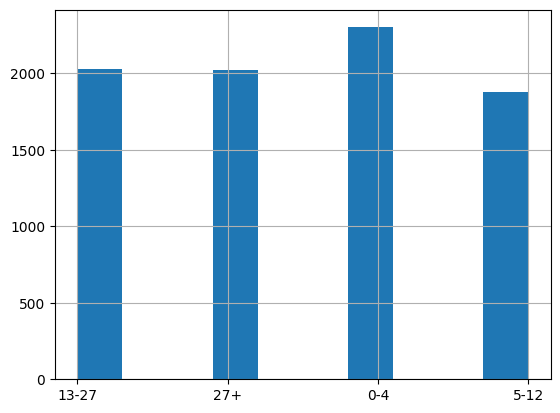

In [16]:
merged_df['batter_runs_cat'] = pd.cut(merged_df['batter_runs'], bins = [-1, 5, 13, 27, np.inf], labels = ['0-4', '5-12', '13-27', '27+'])
# pd.qcut(merged_df['batter_runs'], 4, labels = False, retbins=True)
merged_df['batter_runs_cat'].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split Train Test Data Sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42);
for train_index, test_index in split.split(merged_df, merged_df['batter_runs_cat']):
    strat_train_set = merged_df.loc[train_index]
    strat_test_set = merged_df.loc[test_index]

print(strat_test_set['batter_runs_cat'].value_counts() / len(strat_test_set));

# Drop the categorical column used for strat
for set_ in (strat_test_set, strat_train_set):
    set_.drop('batter_runs_cat', axis = 1, inplace = True)


strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

batter_runs_cat
0-4      0.279465
13-27    0.246659
27+      0.245443
5-12     0.228433
Name: count, dtype: float64


## Attach the bowler type data to the dataset

In [18]:
def get_player_v_bowlers(player_name: str, match_ids, innings=[1, 2], ) -> pd.DataFrame:
    player_data = data.loc[
        (data['batter'] == player_name) & (data['innings'].isin(
            innings)) & (data['match_id'].isin(match_ids))
    ]

    player_data.head()

    # Convert all medium bowlers to fast
    player_data.loc[player_data['bowler_type'] ==
                    'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
    player_data.loc[player_data['bowler_type'] ==
                    'Right arm Medium', 'bowler_type'] = 'Right arm Fast'

    player_data['out'] = (player_data['wicket_type'] != '0') & (
        player_data['wicket_type'] != 'run out')

    cols = ['batter', 'non_striker', 'runs_by_bat', 'out',
            'won', 'innings', 'over', 'delivery', 'bowler_type']
    player_data = player_data[cols]

    gp = player_data.groupby('bowler_type')

    player_v_bowler = pd.DataFrame()
    player_v_bowler['strike_rate'] = round(gp['runs_by_bat'].mean() * 100, 3)
    player_v_bowler['strike_rate_std'] = gp['runs_by_bat'].std()
    player_v_bowler['wickets'] = gp['out'].sum()
    player_v_bowler['deliveries_per_wicket'] = round(1 / gp['out'].mean(), 3)
    player_v_bowler['deliveries'] = gp.size()
    return player_v_bowler


# for player in data['batter'].unique():

#     # Attaching the player_v_bowler results to this dataset
#     print(f"Updating {player}...")
#     print(strat_train_set[strat_train_set['batter' == player]]);
#     player_scores = strat_train_set[strat_train_set['batter' == player]]

#     player_vs_bowler = get_player_v_bowlers(player_name, player_scores.index)

#     bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
#                     'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
#     for bowler_type in bowler_types:
#         if bowler_type in player_vs_bowler.index:
#             player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
#                                                                                  'strike_rate'] / 100 * player_scores[bowler_type]
#             player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
#                 player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
#             player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
#             player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
#                                                                                      'deliveries_per_wicket']
#         else:
#             player_scores[bowler_type] = 0
#             player_scores[f'{bowler_type} Expected Runs'] = 0
#             player_scores[f'{bowler_type} Expected Wickets'] = 0
#             player_scores[f'{bowler_type} Strike Rate'] = 0
#             player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0

#     # strat_train_set.update(player_scores)

match_ids_in_train_set = strat_train_set['match_id']
def attach_bowler_type_stats(player_scores):
    
    player_name = player_scores['batter'].iloc[0]
    player_vs_bowler = get_player_v_bowlers(player_name, match_ids = match_ids_in_train_set);
    
    bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
                    'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
    for bowler_type in bowler_types:
        if bowler_type in player_vs_bowler.index:
            player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
                                                                                 'strike_rate'] / 100 * player_scores[bowler_type]
            player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
                player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
            player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
                                                                                     'deliveries_per_wicket']
        else:
            player_scores[bowler_type] = 0
            player_scores[f'{bowler_type} Expected Runs'] = 0
            player_scores[f'{bowler_type} Expected Wickets'] = 0
            player_scores[f'{bowler_type} Strike Rate'] = 0
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0
            
    return player_scores

 # Appending bowler type data to the training set   
gp = strat_train_set.groupby('batter')
result = gp.apply(attach_bowler_type_stats);

strat_train_set = result.reset_index(drop=True)

# Appending the bowler type data to the testing set -> Only the training summaries are used (test set averages, strikerates are not used)
result = gp.apply(attach_bowler_type_stats);
strat_test_set = result.reset_index(drop=True)

# Saving checkpoint
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\978985555.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = gp.apply(attach_bowler_type_stats);
C:\Users\kauad\AppData\Local\Temp\ipykernel_14984\978985555.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = gp.apply(attach_bowler_type_stats);


In [19]:
# Additional Features Experimenting

bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
bowler_types_expected_wickets_cols = [bowler_type + " Expected Wickets" for bowler_type in bowler_types]
bowler_types_expected_runs_cols = [bowler_type + " Expected Runs" for bowler_type in bowler_types]

strat_train_set['expected_wickets'] = strat_train_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
strat_train_set['expected_runs'] = strat_train_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
strat_train_set['expected_runs'] = strat_train_set['expected_runs'] / np.sqrt(strat_train_set['expected_wickets']) 

strat_test_set['expected_wickets'] = strat_test_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
strat_test_set['expected_runs'] = strat_test_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
strat_test_set['expected_runs'] = strat_test_set['expected_runs'] / np.sqrt(strat_test_set['expected_wickets'])


print(strat_train_set.loc[:, ['batter_runs', 'expected_runs']].corr())
strat_train_set.loc[:, ['batter_runs', 'expected_runs']]

               batter_runs  expected_runs
batter_runs       1.000000       0.406255
expected_runs     0.406255       1.000000


,batter_runs,expected_runs
0,27,75.239733
1,2,50.300966
2,5,58.000050
3,28,62.951376
4,28,44.419061
...,...,...
6575,0,6.534860
6576,1,7.131630
6577,14,44.078949
6578,2,33.702106


In [20]:
# Remove the columns that cannot be known by the ongoing match state
# Example: The out or wicket type is not known during the match
strat_test_set.drop(['wicket_type', 'out', 'match_id', 'won'], axis = 1, inplace = True)
strat_train_set.drop(['wicket_type', 'out', 'match_id', 'won'], axis = 1, inplace = True)


In [21]:
# fill 0 for NaN
strat_test_set.fillna(value=0, inplace=True)
strat_train_set.fillna(value=0, inplace=True)
# Saving checkpoint
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

In [22]:
import pandas as pd
import numpy as np

strat_train_set = pd.read_csv('strat_train_set.csv');

# Possible Targets: But we'll be only concerned with the number of runs scored for now
targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']


# Match State -> Only data available in a given moment of a match. This will be the input
X = strat_train_set.drop(targets, axis=1)
y = strat_train_set['batter_runs']

# Replace infinity values by a high constant value
# These occured at deliveries per wicket column
# So infinity can be thought as the batsman never getting out
# i.e 120 balls faced, hence replacing inf with 120
X.replace([np.inf], 120, inplace=True);

# Preprocess the data
X_processed = pd.get_dummies(data=X,dtype=int)

In [23]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6580 entries, 0 to 6579
Columns: 621 entries, Unnamed: 0 to batting_team_Zimbabwe
dtypes: bool(2), float64(36), int32(577), int64(6)
memory usage: 16.6 MB


In [24]:
X.drop('Unnamed: 0', inplace=True, axis=1)
X.columns

Index(['batter', 'innings', 'wickets_fallen', 'bowling_team', 'batting_team',
       'toss_winner', 'runs_remain', 'first_ball', 'current_team_total',
       'is_powerplay', 'Left arm Fast', 'Left arm Orthodox',
       'Left arm Wrist spin', 'Right arm Fast', 'Right arm Legbreak',
       'Right arm Offbreak', 'recent_form', 'venue_mean_total',
       'venue_first_bat_won_ratio', 'is_host', 'Left arm Fast Expected Runs',
       'Left arm Fast Expected Wickets', 'Left arm Fast Strike Rate',
       'Left arm Fast Deliveries Per Wicket', 'Right arm Fast Expected Runs',
       'Right arm Fast Expected Wickets', 'Right arm Fast Strike Rate',
       'Right arm Fast Deliveries Per Wicket',
       'Left arm Orthodox Expected Runs', 'Left arm Orthodox Expected Wickets',
       'Left arm Orthodox Strike Rate',
       'Left arm Orthodox Deliveries Per Wicket',
       'Left arm Wrist spin Expected Runs',
       'Left arm Wrist spin Expected Wickets',
       'Left arm Wrist spin Strike Rate',
      

In [25]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

# Cross Validation (Train Set)
Baseline model without any hyperparameter tuning or complex feature engineering

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(random_state=42, criterion='absolute_error')
scores = cross_val_score(forest_reg, X_processed, y, scoring="neg_mean_absolute_error", cv = 10)


display_scores(scores)

KeyboardInterrupt: 

In [27]:
import matplotlib.pyplot as plt

forest_reg.fit(X_train, y_train)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, forest_reg.predict(X_val), alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'X_train' is not defined

The random forest regressor gives a good result compared to the earlier models tested. \
The mean rmse is 8.33, which means that if the model predicts that the batsman will score 20, the average error will be in 8 runs width so it can be either 28 or 12

# Stratified K Fold Validation Set

### GradientBoosting Model

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor


# Split data into training and validating sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=200, random_state=42, loss= 'absolute_error')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.2f}")

Root Mean Squared Error (RMSE): 15.06
Mean Absolute Error (MAE): 10.39


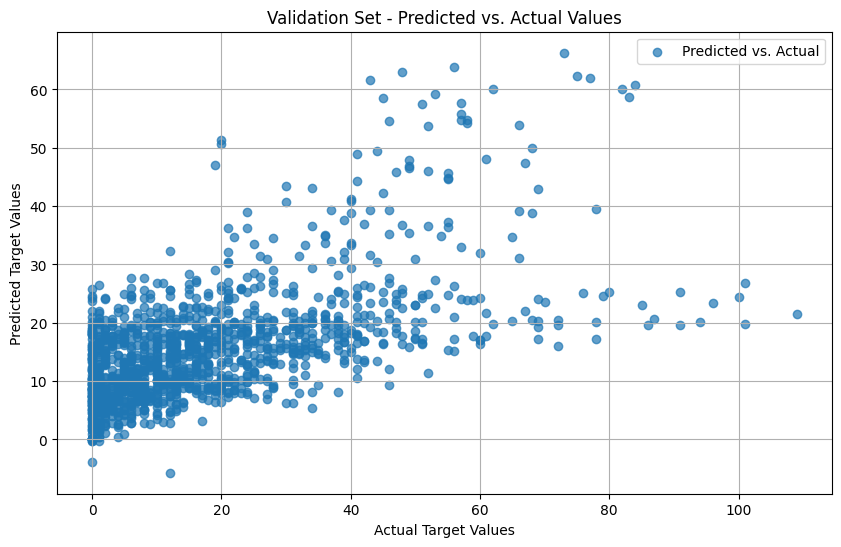

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=42, n_estimators=1000, loss='reg:pseudohubererror')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the val set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.2f}")

c:\Users\kauad\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:15:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 16.70
Mean Absolute Error (MAE): 12.04


# Random Forest Regressor

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_estimators=100, criterion='absolute_error')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.2f}")

Mean Absolute Error (MAE): 10.94


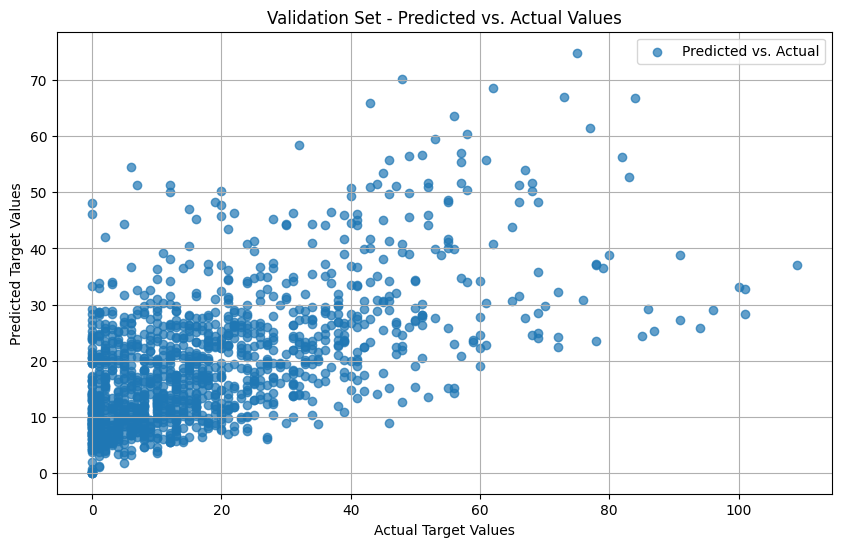

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                          Feature  Gini Importance
43                  expected_runs     1.142630e-01
4                     runs_remain     8.861803e-02
42               expected_wickets     4.033959e-02
5                      first_ball     3.700723e-02
22   Right arm Fast Expected Runs     3.569240e-02
..                            ...              ...
392             batter_Muktar Ali     0.000000e+00
475          batter_Rony Talukdar     0.000000e+00
595            batter_Zakir Hasan     0.000000e+00
313             batter_KOA Powell     0.000000e+00
298               batter_K Rabada    -1.247915e-22

[621 rows x 2 columns]


### Deep NN

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

scaler = StandardScaler()
X_processed_scaled = scaler.fit_transform(X_processed)
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Define the model architecture
model = keras.Sequential([
  layers.Dense(1024, activation='leaky_relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 256 neurons and ReLU activation
  layers.Dense(512, activation='leaky_relu'),  # First hidden layer with 256 neurons and ReLU activation
  layers.Dense(256, activation='leaky_relu'),  # Second hidden layer with 128 neurons and ReLU activation
  layers.Dense(64, activation='leaky_relu'),  # Third hidden layer with 64 neurons and ReLU activation
  layers.Dense(32, activation='leaky_relu'),  # Third hidden layer with 64 neurons and ReLU activation
  layers.Dense(1)  # Output layer with 1 neuron for regression (single value prediction)
])

# Compile the model
model.compile(loss='mae', optimizer='adam')  # Mean absolute error loss and Adam optimizer

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model with validation split
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])  # Added validation data

# Access training and validation loss history for further analysis (optional)
train_loss = history.history['loss']
val_loss = history.history['val_loss']


c:\Users\kauad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 47.7290 - val_loss: 12.8486
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 14.3828 - val_loss: 12.2837
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 13.0917 - val_loss: 12.8769
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.5299 - val_loss: 11.5213
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.3348 - val_loss: 11.2948
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 11.6315 - val_loss: 11.4514
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.3355 - val_loss: 11.9252
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.5493 - val_loss: 11.0694
Epoch 9/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.8791 - val_loss: 11.1915
Epoch 10/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.7176 - val_loss: 11.1958
Epoch 11/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.3710 - val_loss: 11.0968
Epoch 12

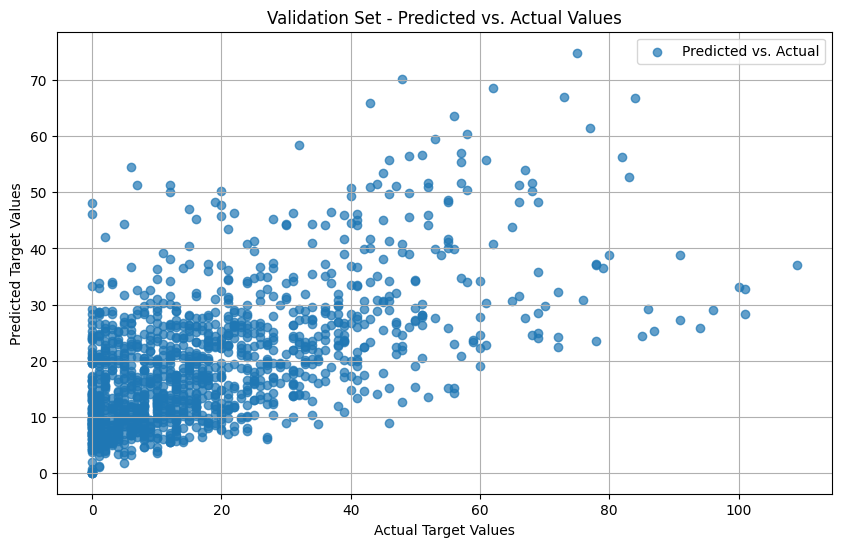

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

#### Hyperparameter Tunning using RandomizedSearchCV

In [46]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()
X_test_copy = X_val.copy()
y_test_copy = y_val.copy()

In [49]:
from sklearn.model_selection import RandomizedSearchCV

In [50]:
# Define hyperparameter grids
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

In [52]:
# Perform RandomizedSearchCV for RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, 
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train_copy, y_train_copy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\kauad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
87 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kauad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kauad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\kauad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300,
                                                         400]},
                   random_state=42, verbose=2)

In [53]:
# Perform RandomizedSearchCV for GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42, loss='absolute_error')
gbr_random = RandomizedSearchCV(estimator=gbr, param_distributions=param_grid_gbr, 
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
gbr_random.fit(X_train_copy, y_train_copy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=GradientBoostingRegressor(loss='absolute_error',
                                                       random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [54]:
# Perform RandomizedSearchCV for XGBRegressor
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid_xgb, 
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_random.fit(X_train_copy, y_train_copy)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [55]:
# Display the best hyperparameters
print("Best parameters for RandomForestRegressor:", rf_random.best_params_)
print("Best parameters for GradientBoostingRegressor:", gbr_random.best_params_)
print("Best parameters for XGBRegressor:", xgb_random.best_params_)

Best parameters for RandomForestRegressor: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best parameters for GradientBoostingRegressor: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 6, 'learning_rate': 0.05}
Best parameters for XGBRegressor: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [56]:
# Function to calculate RMSE
def calculate_rmse(model, X, y):
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

# Get the best models
best_rf = rf_random.best_estimator_
best_gbr = gbr_random.best_estimator_
best_xgb = xgb_random.best_estimator_

# Calculate RMSE for each model on the validation set
rmse_rf = calculate_rmse(best_rf, X_test_copy, y_test_copy)
rmse_gbr = calculate_rmse(best_gbr, X_test_copy, y_test_copy)
rmse_xgb = calculate_rmse(best_xgb, X_test_copy, y_test_copy)

# Print the RMSE for each model
print(f"RandomForestRegressor RMSE: {rmse_rf}")
print(f"GradientBoostingRegressor RMSE: {rmse_gbr}")
print(f"XGBRegressor RMSE: {rmse_xgb}")

RandomForestRegressor RMSE: 16.29590763729268
GradientBoostingRegressor RMSE: 14.915155958442243
XGBRegressor RMSE: 14.781671477668889


#### Hyperparameter Tunning using GridSearchCV

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
# Define parameter grids around the best parameters obtained from RandomizedSearchCV
param_grid_rf = {
    'n_estimators': [300, 400, 500],
    'max_depth': [15, 20, 25],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [False]
}

param_grid_gb = {
    'n_estimators': [250, 300, 350],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.03, 0.05, 0.07],
    'min_samples_split': [8, 10],
    'min_samples_leaf': [1, 2],
    'subsample': [0.6, 0.8]
}

param_grid_xgb = {
    'n_estimators': [80, 100, 120],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [64]:
rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_copy, y_train_copy)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [15, 20, 25],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [300, 400, 500]},
             verbose=2)

In [65]:
gb = GradientBoostingRegressor()
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=3, n_jobs=-1, verbose=2)
grid_search_gb.fit(X_train_copy, y_train_copy)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [66]:
xgb = XGBRegressor()
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train_copy, y_train_copy)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [4, 5, 6], 'n_estimators': [80, 100, 120],
                         'subsample': [0.7, 0.8, 0.9]},
             verbose=2)

In [67]:
# Best parameters
best_params_rf = grid_search_rf.best_params_
# best_params_gb = grid_search_gb.best_params_
best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for RandomForestRegressor:", best_params_rf)
# print("Best parameters for GradientBoostingRegressor:", best_params_gb)
print("Best parameters for XGBRegressor:", best_params_xgb)

Best parameters for RandomForestRegressor: {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 500}
Best parameters for XGBRegressor: {'colsample_bytree': 0.9, 'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


In [68]:
# Train models with the best parameters
rf_best = RandomForestRegressor(**best_params_rf).fit(X_train_copy, y_train_copy)
# gb_best = GradientBoostingRegressor(**best_params_gb).fit(X_train_copy, y_train_copy)
xgb_best = XGBRegressor(**best_params_xgb).fit(X_train_copy, y_train_copy)

# Predict on validation set
y_pred_rf = rf_best.predict(X_test_copy)
# y_pred_gb = gb_best.predict(X_test_copy)
y_pred_xgb = xgb_best.predict(X_test_copy)

In [69]:
# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test_copy, y_pred_rf))
# rmse_gb = np.sqrt(mean_squared_error(y_test_copy, y_pred_gb))
rmse_xgb = np.sqrt(mean_squared_error(y_test_copy, y_pred_xgb))

print("RMSE for RandomForestRegressor:", rmse_rf)
# print("RMSE for GradientBoostingRegressor:", rmse_gb)
print("RMSE for XGBRegressor:", rmse_xgb)

RMSE for RandomForestRegressor: 16.26581611270589
RMSE for XGBRegressor: 14.70850731751432
